In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from carps.analysis.process_data import get_interpolated_performance_df, load_logs


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


rundir = "/scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/runs"

df, df_cfg = load_logs(rundir=rundir)
print_overview(df)
perf = get_interpolated_performance_df(df)
perf_time = get_interpolated_performance_df(df, x_column="time_norm")

[19:14:37] INFO     Load logs from                                                               ]8;id=620955;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=393016;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py#94\94]8;;\
                    `/scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/runs/logs.csv` and                            
                    associated configs from                                                                        
                    /scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/runs/logs_cfg.csv.                             
                    Preprocess logs.                                                                               

/scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py:100: DtypeWarning: Columns (15,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(logs_fn)


[19:14:38] INFO     Processing raw logs. Normalize n_trials and costs. Calculate trajectory      ]8;id=768769;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=107500;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py#15\15]8;;\
                    (incumbent cost).                                                                              

Index(['n_trials', 'trial_info__config', 'trial_info__instance',
       'trial_info__seed', 'trial_info__budget', 'trial_value__cost',
       'trial_value__time', 'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.bench',
       'problem.instance', 'problem.budget_type', 'problem.metric',
       'problem.yahpo_data_path', 'problem.dimension', 'problem.fid',
       'problem.seed', 'dim', 'trial_info__name', 'trial_info__checkpoint',
       'experiment_id', 'n_trials_norm', 'trial_value__cost_norm',
       'trial_value__cost_inc', 'trial_value__cost_inc_norm', 'time',
       'time_norm'],
      dtype='object')
['AdaptiveDoE-37' 'AdaptiveDoE-EasyStopping' 'AdaptiveDoE-SeqOdds' 'HEBO'
 'SMAC3-BlackBoxFacade']
['BBOB' 'OptBench' 'YAHPO']
['noiseless/5/1/0' 'noiseless/5/10/0' 'noiseless/5/11/0'
 'noiseless/5/12/0' 'noiseless/5/13/0' 'noiseless/5/14/0'
 'noiseless/5/

[19:14:39] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=296677;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=808701;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py#64\64]8;;\
                    budget.                                                                                        

[19:14:40] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=841373;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=148377;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/process_data.py#64\64]8;;\
                    budget.                                                                                        

In [2]:
from carps.analysis.critical_difference import calc_critical_difference
calc_critical_difference(df=df)


[19:14:42] INFO     Lost following experiments: optimizer_id                              ]8;id=410970;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=108277;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/critical_difference.py#23\23]8;;\
                    AdaptiveDoE-37  AdaptiveDoE-EasyStopping  \                                                    
                    problem_id                                                                                     
                    yahpo/so/nb301/CIFAR10/None        -94.406481                                                  
                    NaN                                                                                            
                    yahpo/so/rbv2_glmnet/375/None       -0.960666                                                  
                    NaN                                                                                            
                    yahpo/so/rbv2_super/1053/None       -0.933377                                                  
                    NaN                                                                                            
                    yahpo/so/rbv2_super/1063/None       -0.926801                                                  
                    NaN                                                                                            
                    yahpo/so/rbv2_super/1468/None       -0.974729                                                  
                    -0.975836                                                                                      
                    yahpo/so/rbv2_super/15/None         -0.986783                                                  
                    -0.989633                                                                                      
                                                                                                                   
                    optimizer_id                   AdaptiveDoE-SeqOdds                                             
                    SMAC3-BlackBoxFacade                                                                           
                    problem_id                                                                                     
                    yahpo/so/nb301/CIFAR10/None             -94.744540                                             
                    -94.825253                                                                                     
                    yahpo/so/rbv2_glmnet/375/None            -0.960864                                             
                    -0.960642                                                                                      
                    yahpo/so/rbv2_super/1053/None            -0.963487                                             
                    -0.964575                                                                                      
                    yahpo/so/rbv2_super/1063/None            -0.944029                                             
                    -0.941598                                                                                      
                    yahpo/so/rbv2_super/1468/None                  NaN                                             
                    -0.974831                                                                                      
                    yahpo/so/rbv2_super/15/None                    NaN                                             
                    -0.989200                                                                                      

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/dacbo/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           INFO                                                                           ]8;id=546260;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=77323;file:///scratch/hpc-prf-intexml/cbenjamins/repos/DACBO/lib/SMACBenchmarking/carps/analysis/critical_difference.py#34\34]8;;\
                    Methods: ['AdaptiveDoE-37', 'AdaptiveDoE-EasyStopping',                                        
                    'AdaptiveDoE-SeqOdds', 'SMAC3-BlackBoxFacade']                                                 
                    Average ranks: [3.5        1.62765957 1.69148936 3.18085106]                                   
                    Groups: [array([0, 3]), array([1, 2])]                                                         
                                                                                                                   

In [3]:
from carps.analysis.interval_estimates import plot_interval_estimates

# fig, axes = plot_interval_estimates(performance_data=perf, load_from_pickle=False, figure_filename="figures/plot_interval_estimates.pdf")

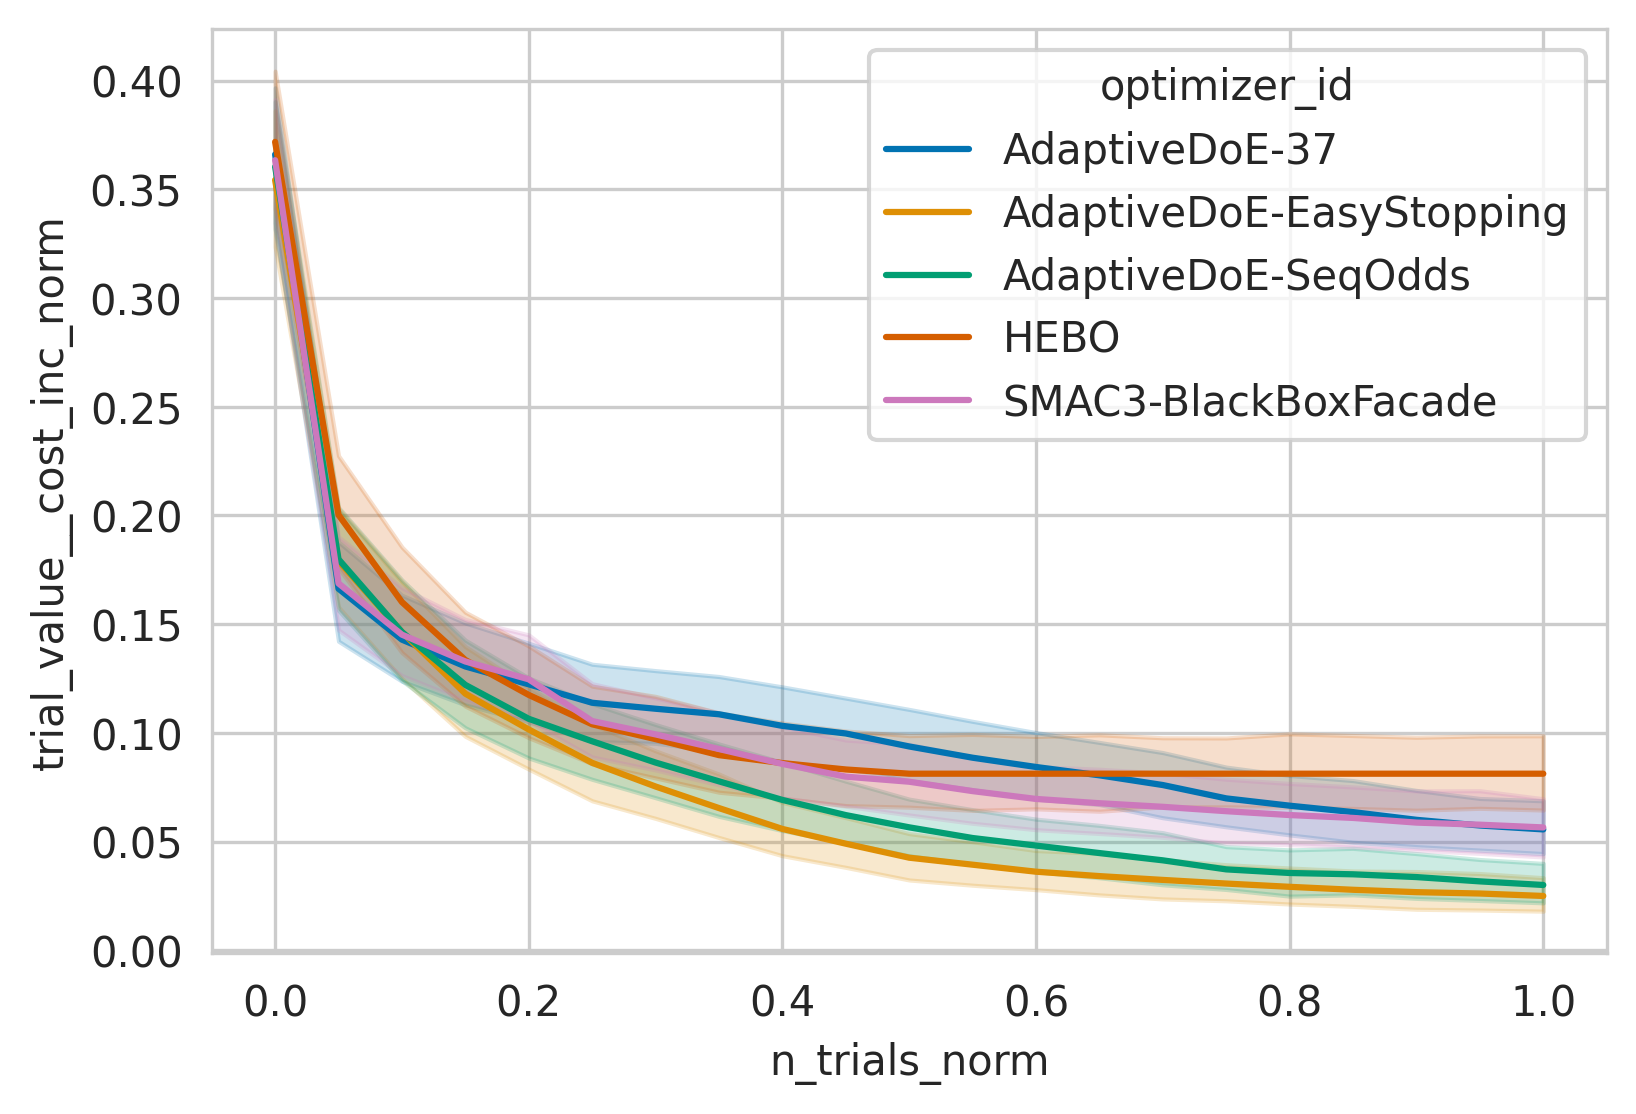

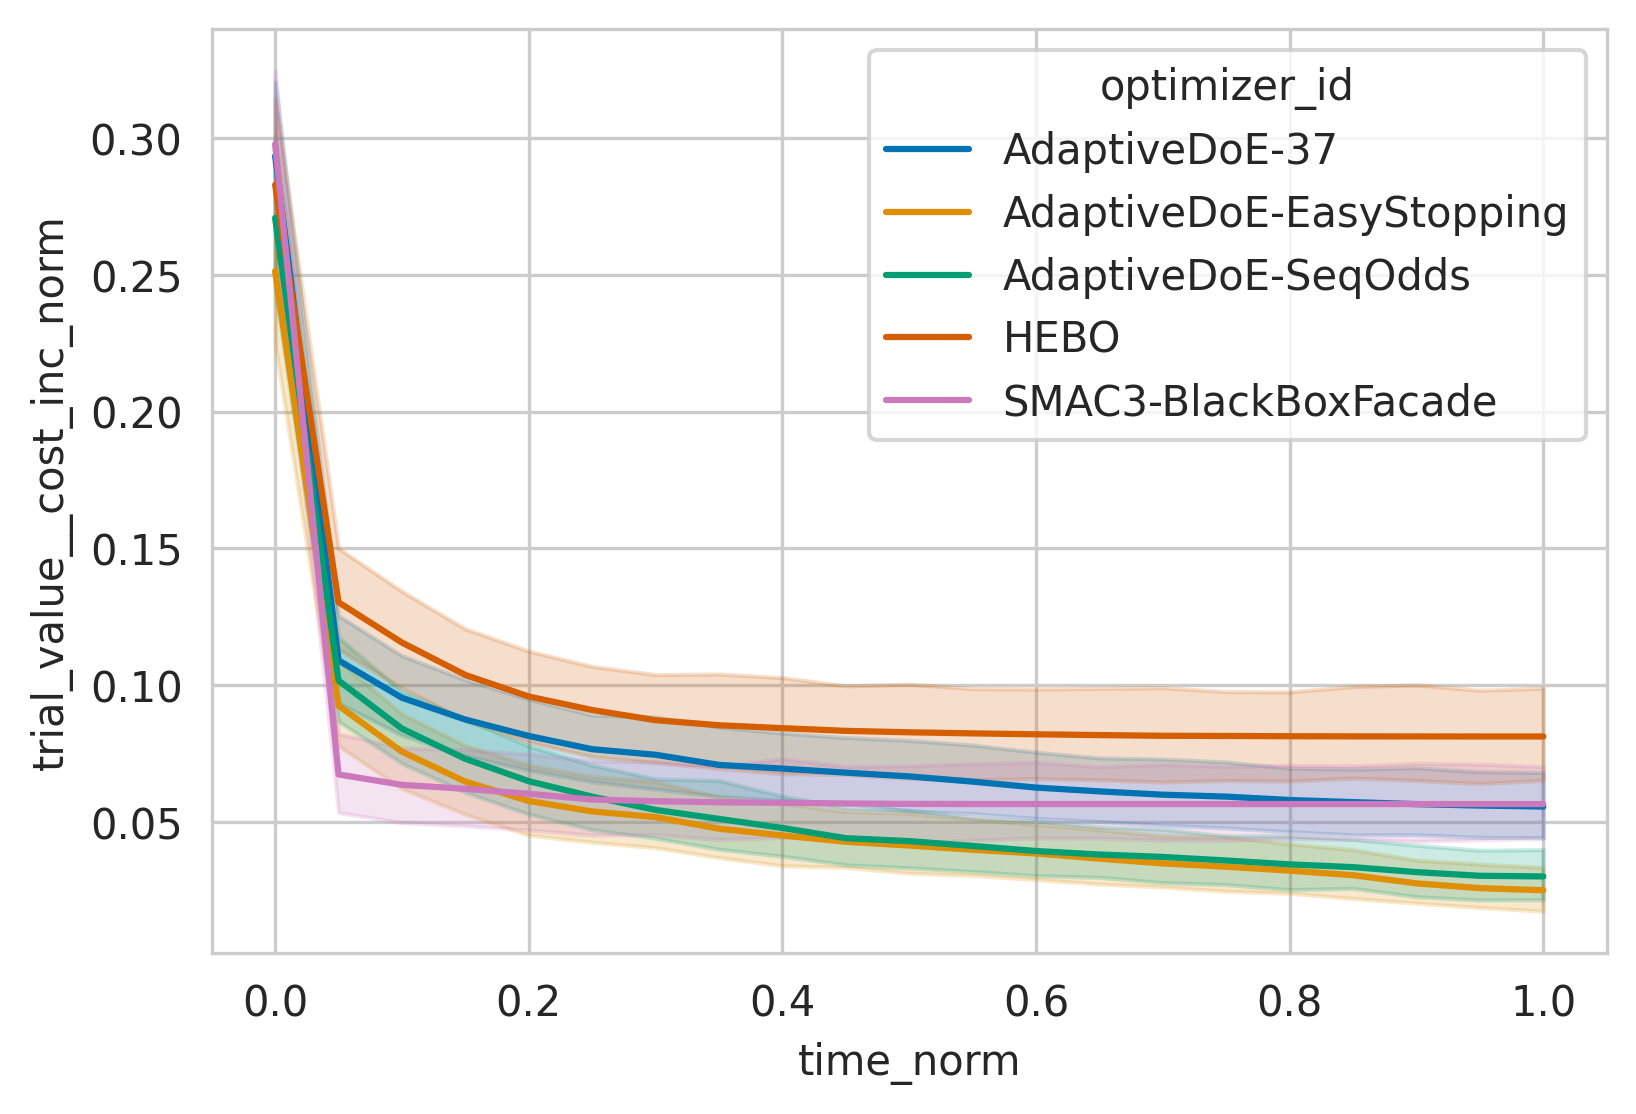

In [4]:
from carps.analysis.performance_over_time import plot_performance_over_time
lineplot_kwargs = dict()
fig, ax = plot_performance_over_time(df=perf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename="figures/performance_over_time_trials.pdf", figsize=(6,4), **lineplot_kwargs)
fig, ax = plot_performance_over_time(df=perf_time, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename="figures/performance_over_time_elapsed.pdf", figsize=(6,4), **lineplot_kwargs)

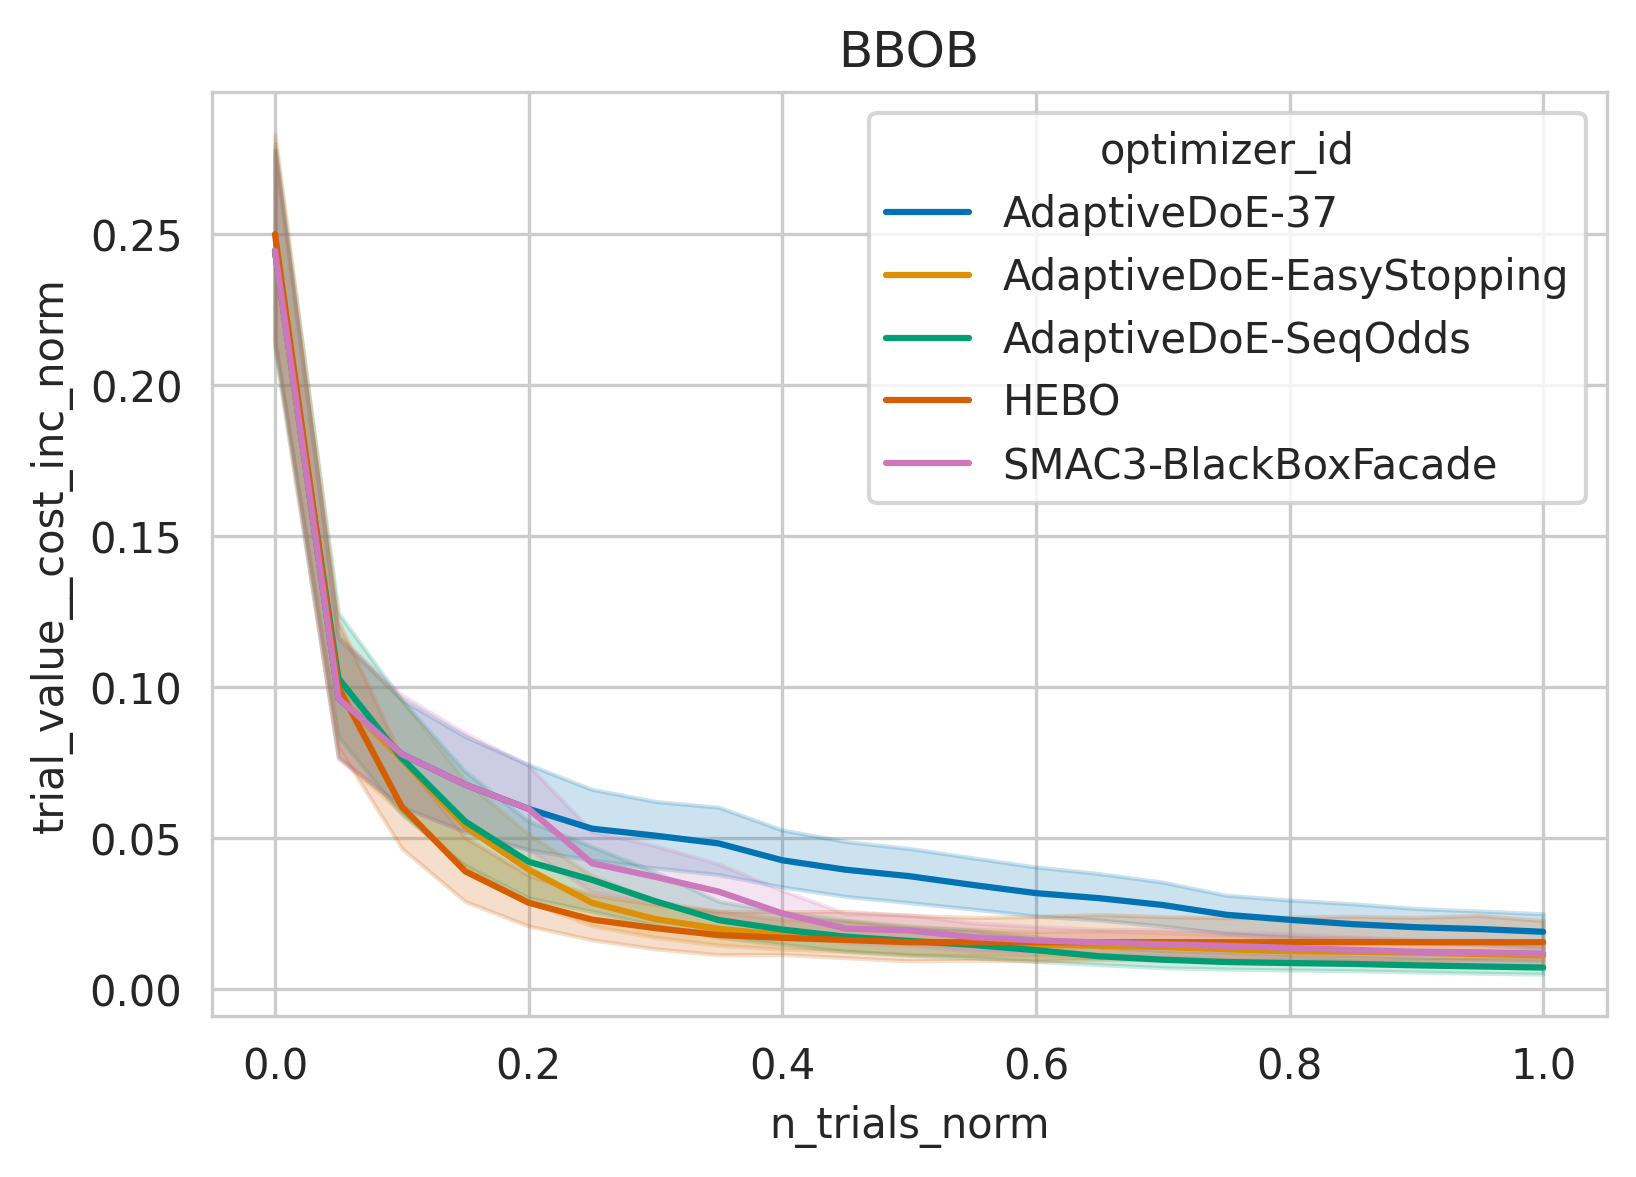

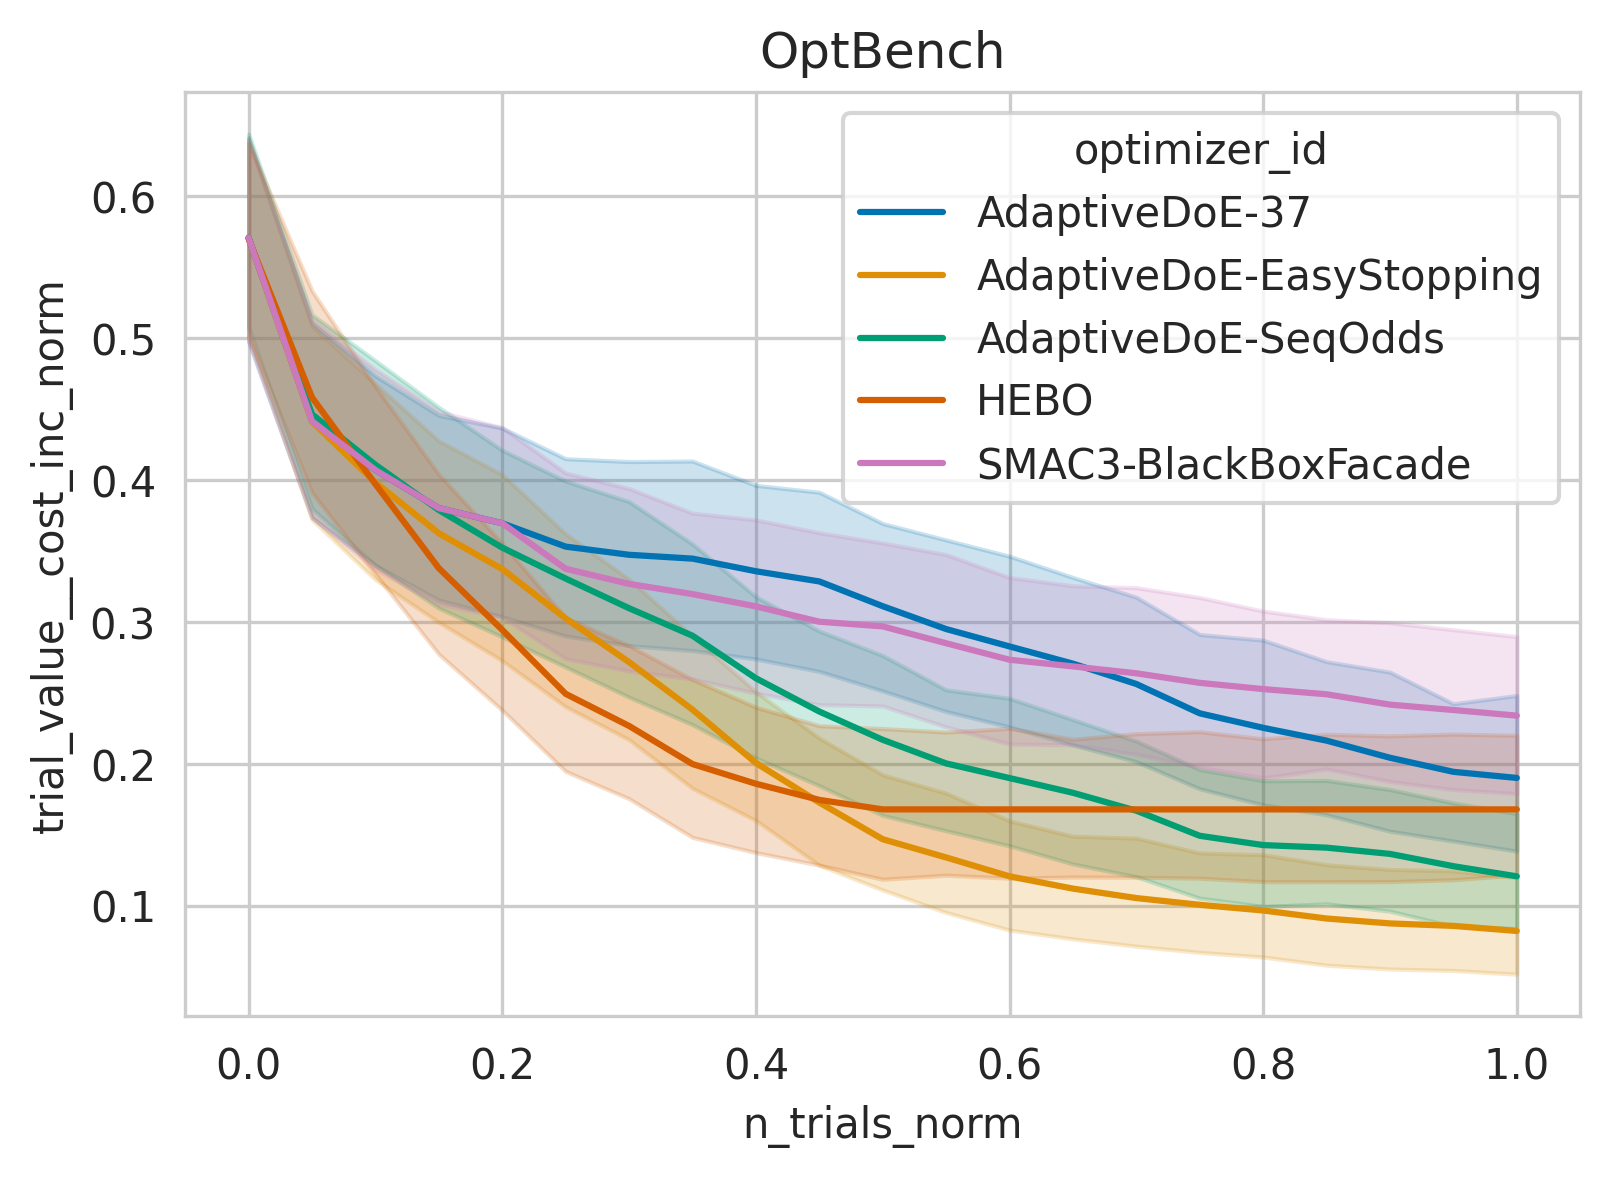

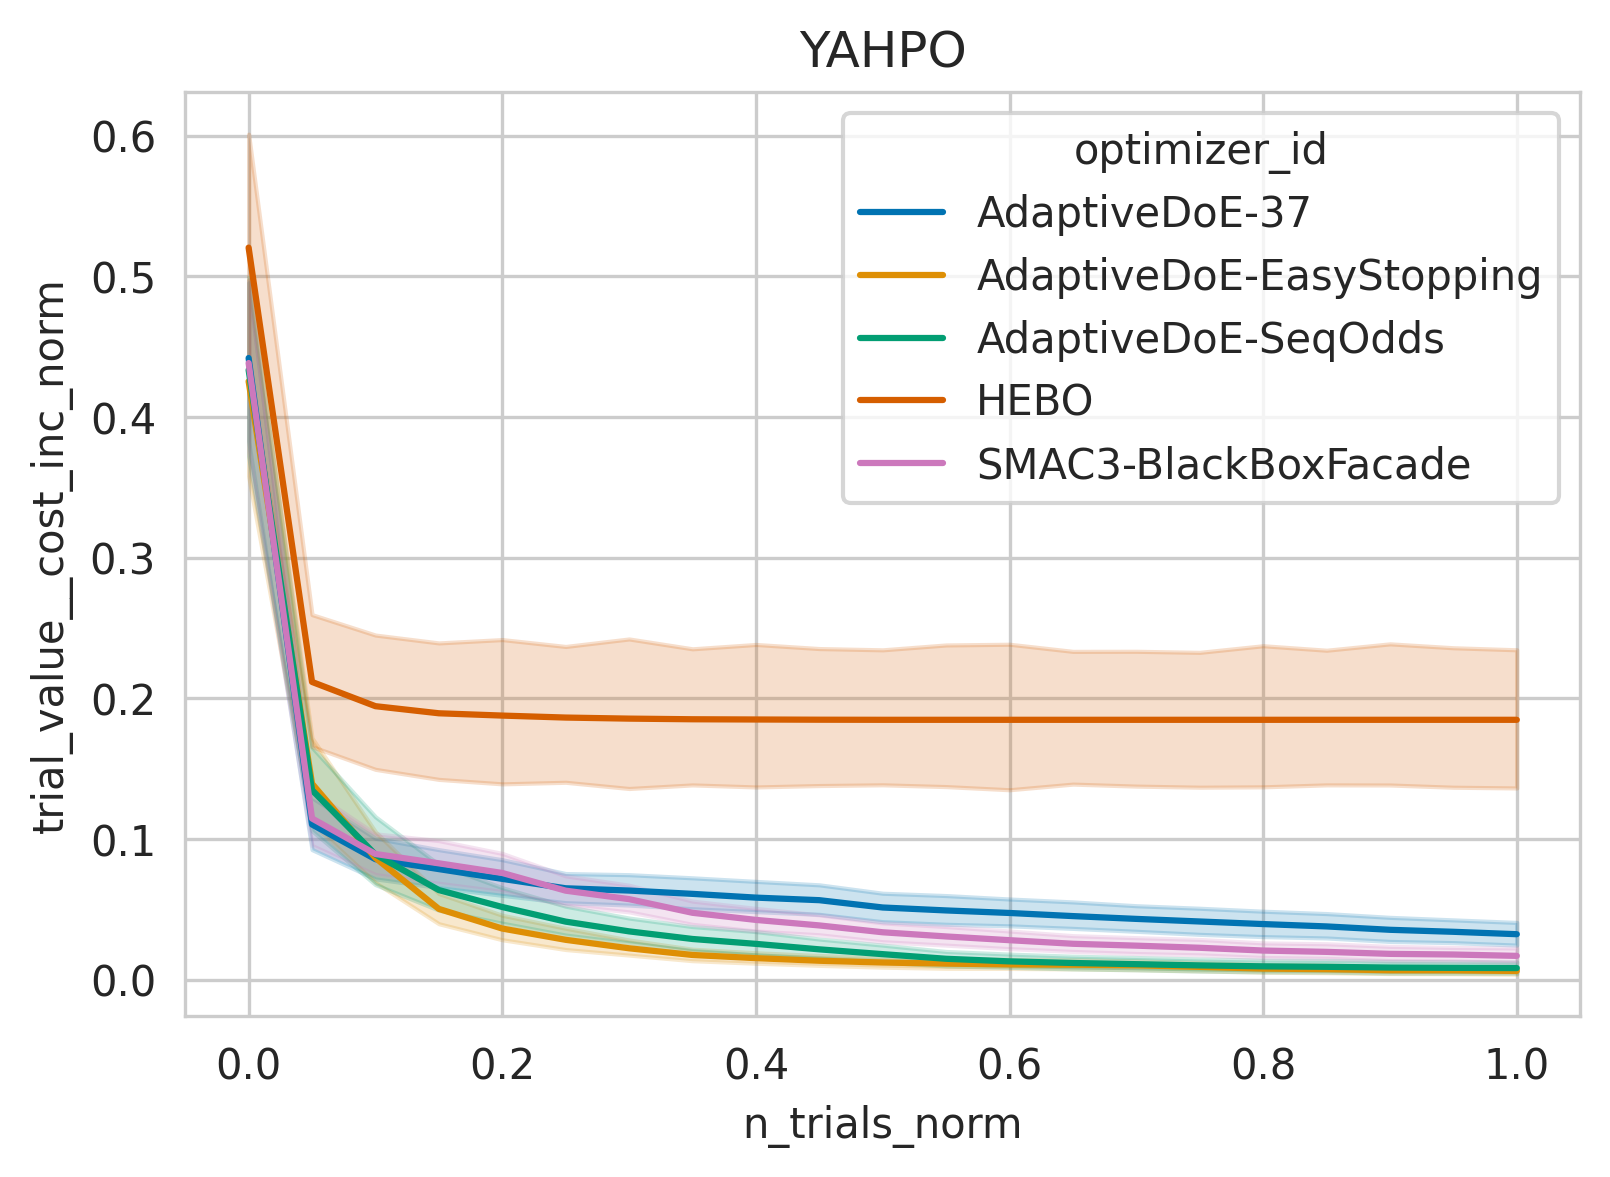

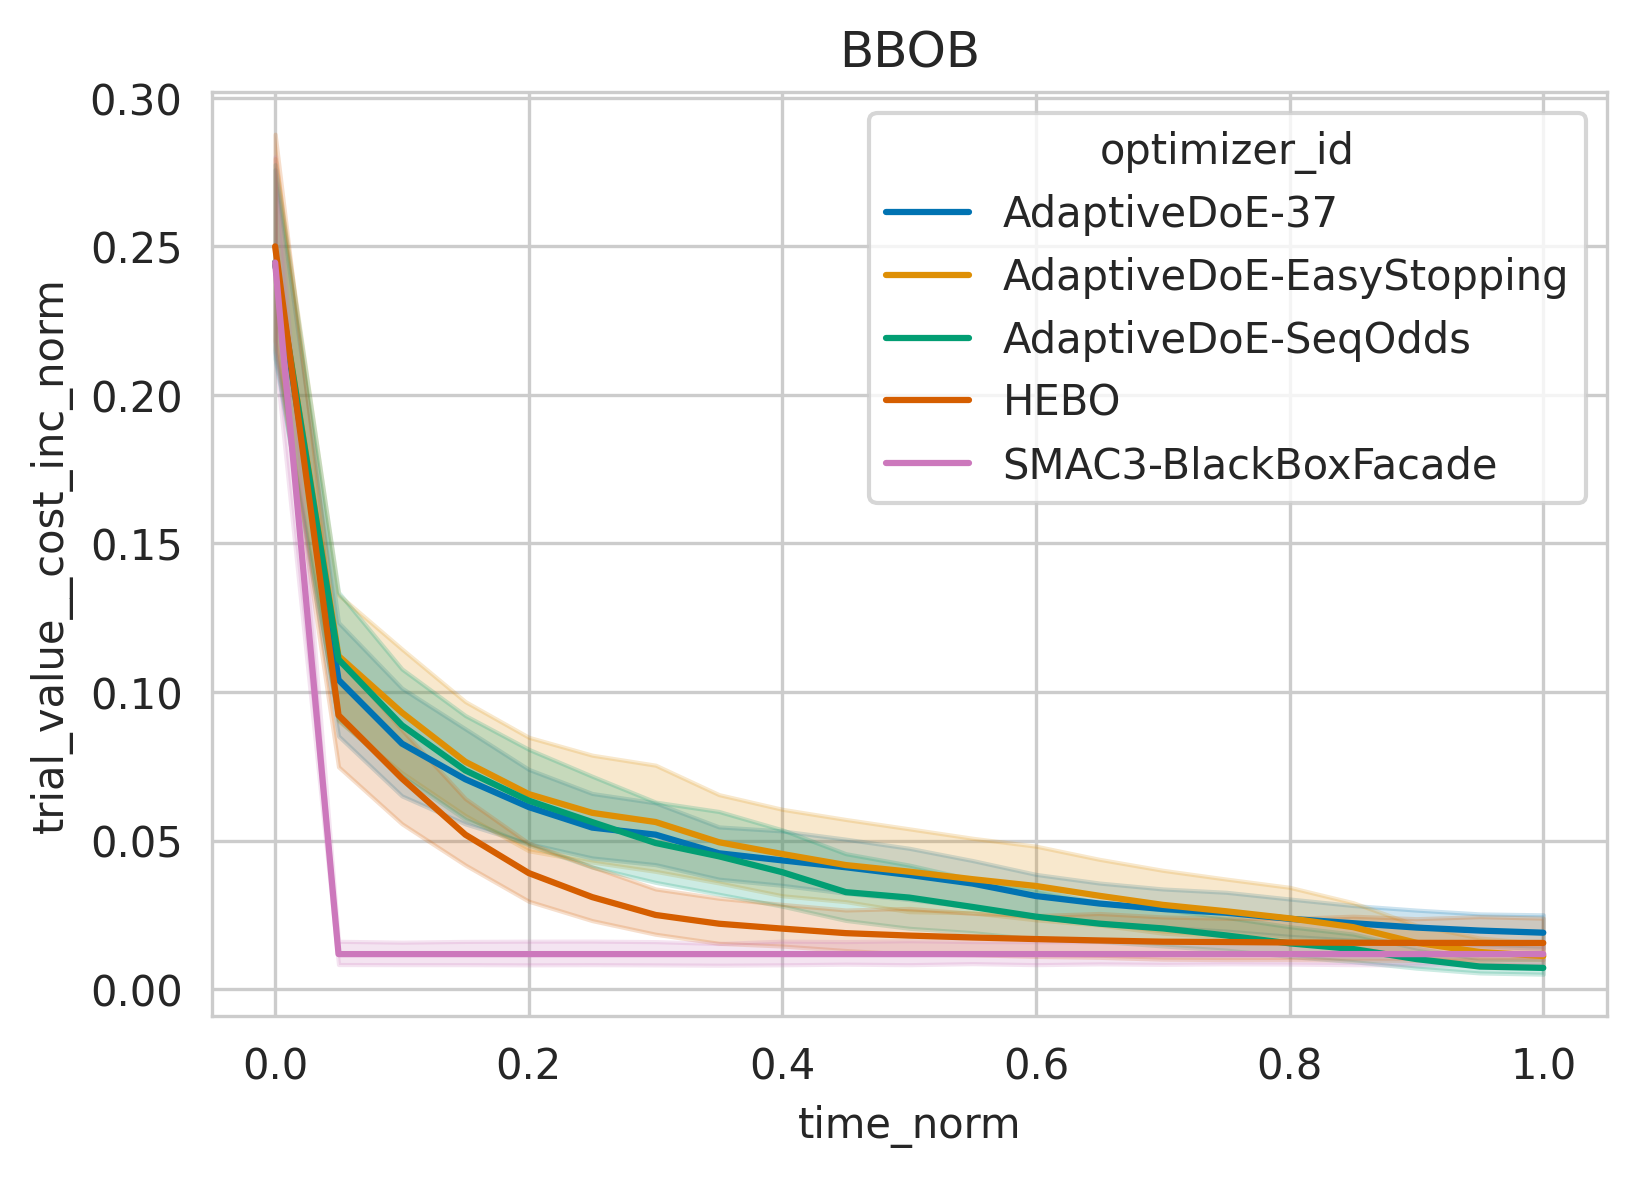

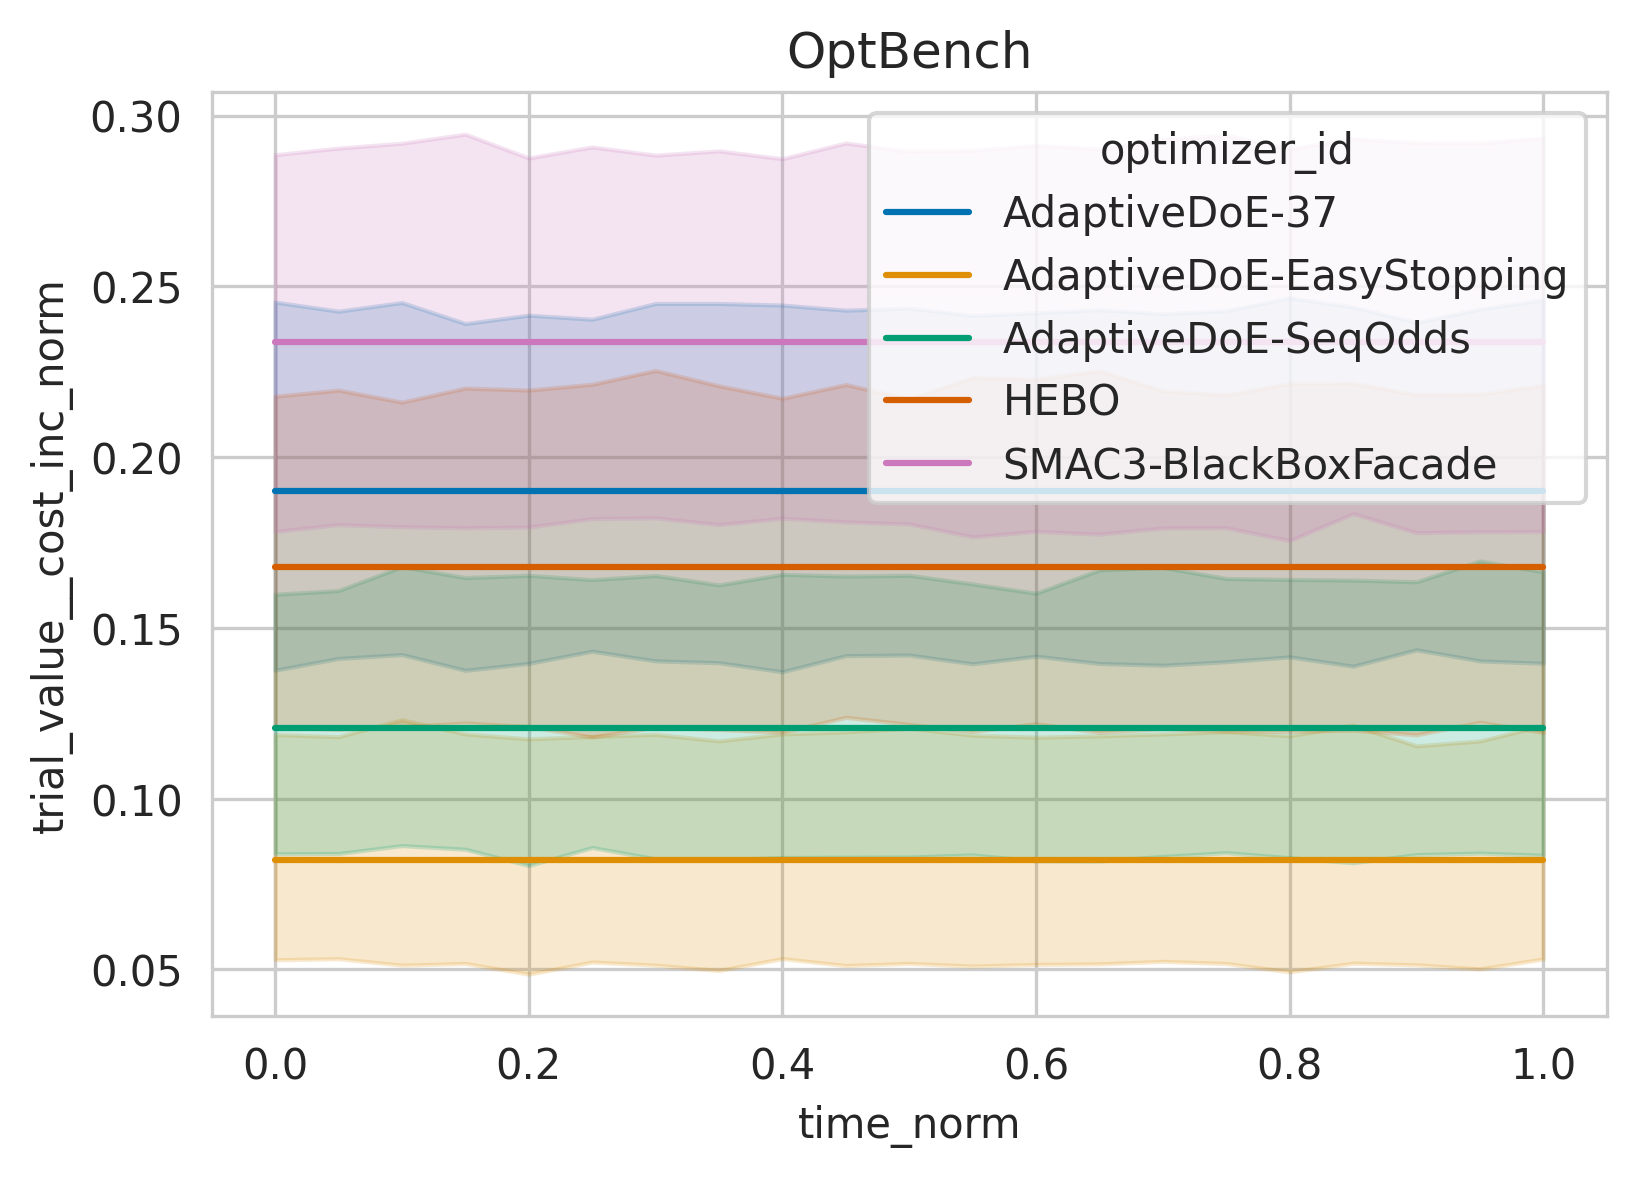

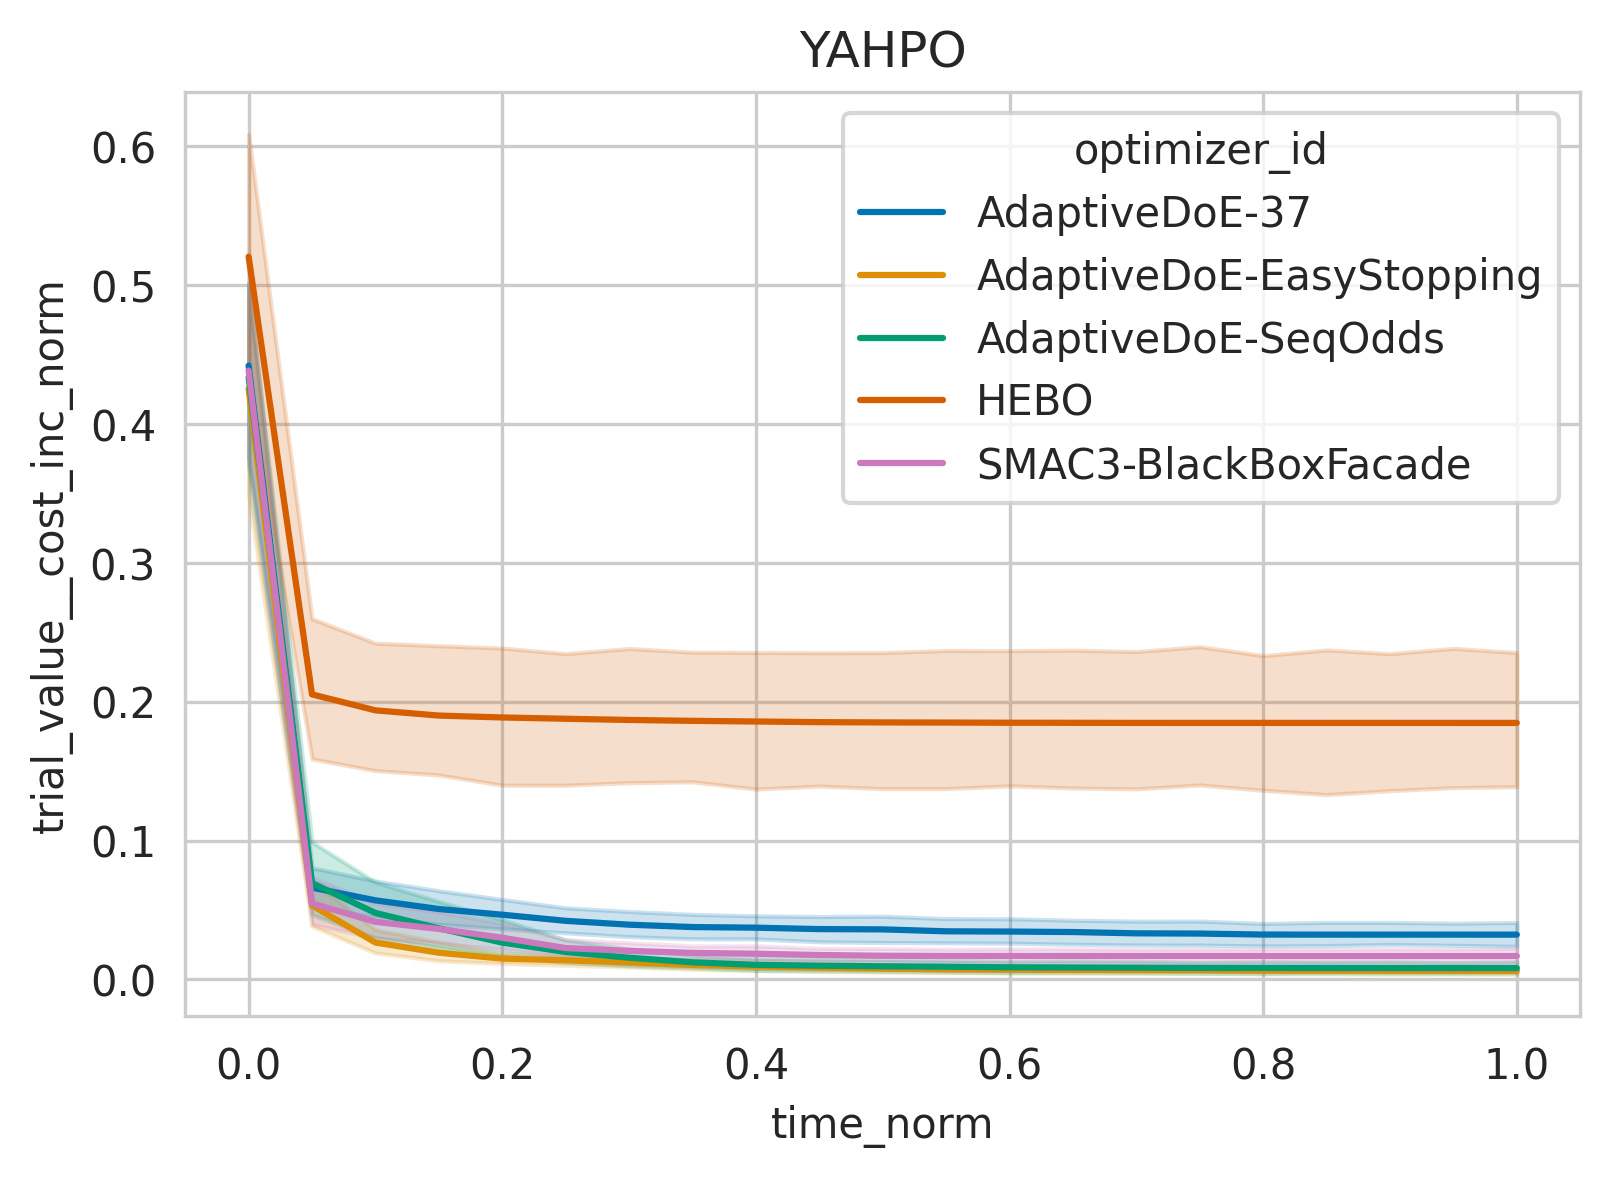

In [5]:
# Plot per benchmark
from carps.analysis.utils import get_color_palette, savefig
from carps.analysis.performance_over_time import plot_performance_over_time

palette = get_color_palette(perf)
lineplot_kwargs = dict()

# Iterations
for gid, gdf in perf.groupby(by="benchmark_id"):    
    figure_filename = f"figures/performance_over_time_trials_{gid}.pdf"
    fig, ax = plot_performance_over_time(df=gdf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
    ax.set_title(gid)
    savefig(fig, figure_filename)
    plt.show()

# Elapsed time
for gid, gdf in perf_time.groupby(by="benchmark_id"):    
    figure_filename = f"figures/performance_over_time_elapsed_{gid}.pdf"
    fig, ax = plot_performance_over_time(df=gdf, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
    ax.set_title(gid)
    savefig(fig, figure_filename)
    plt.show()

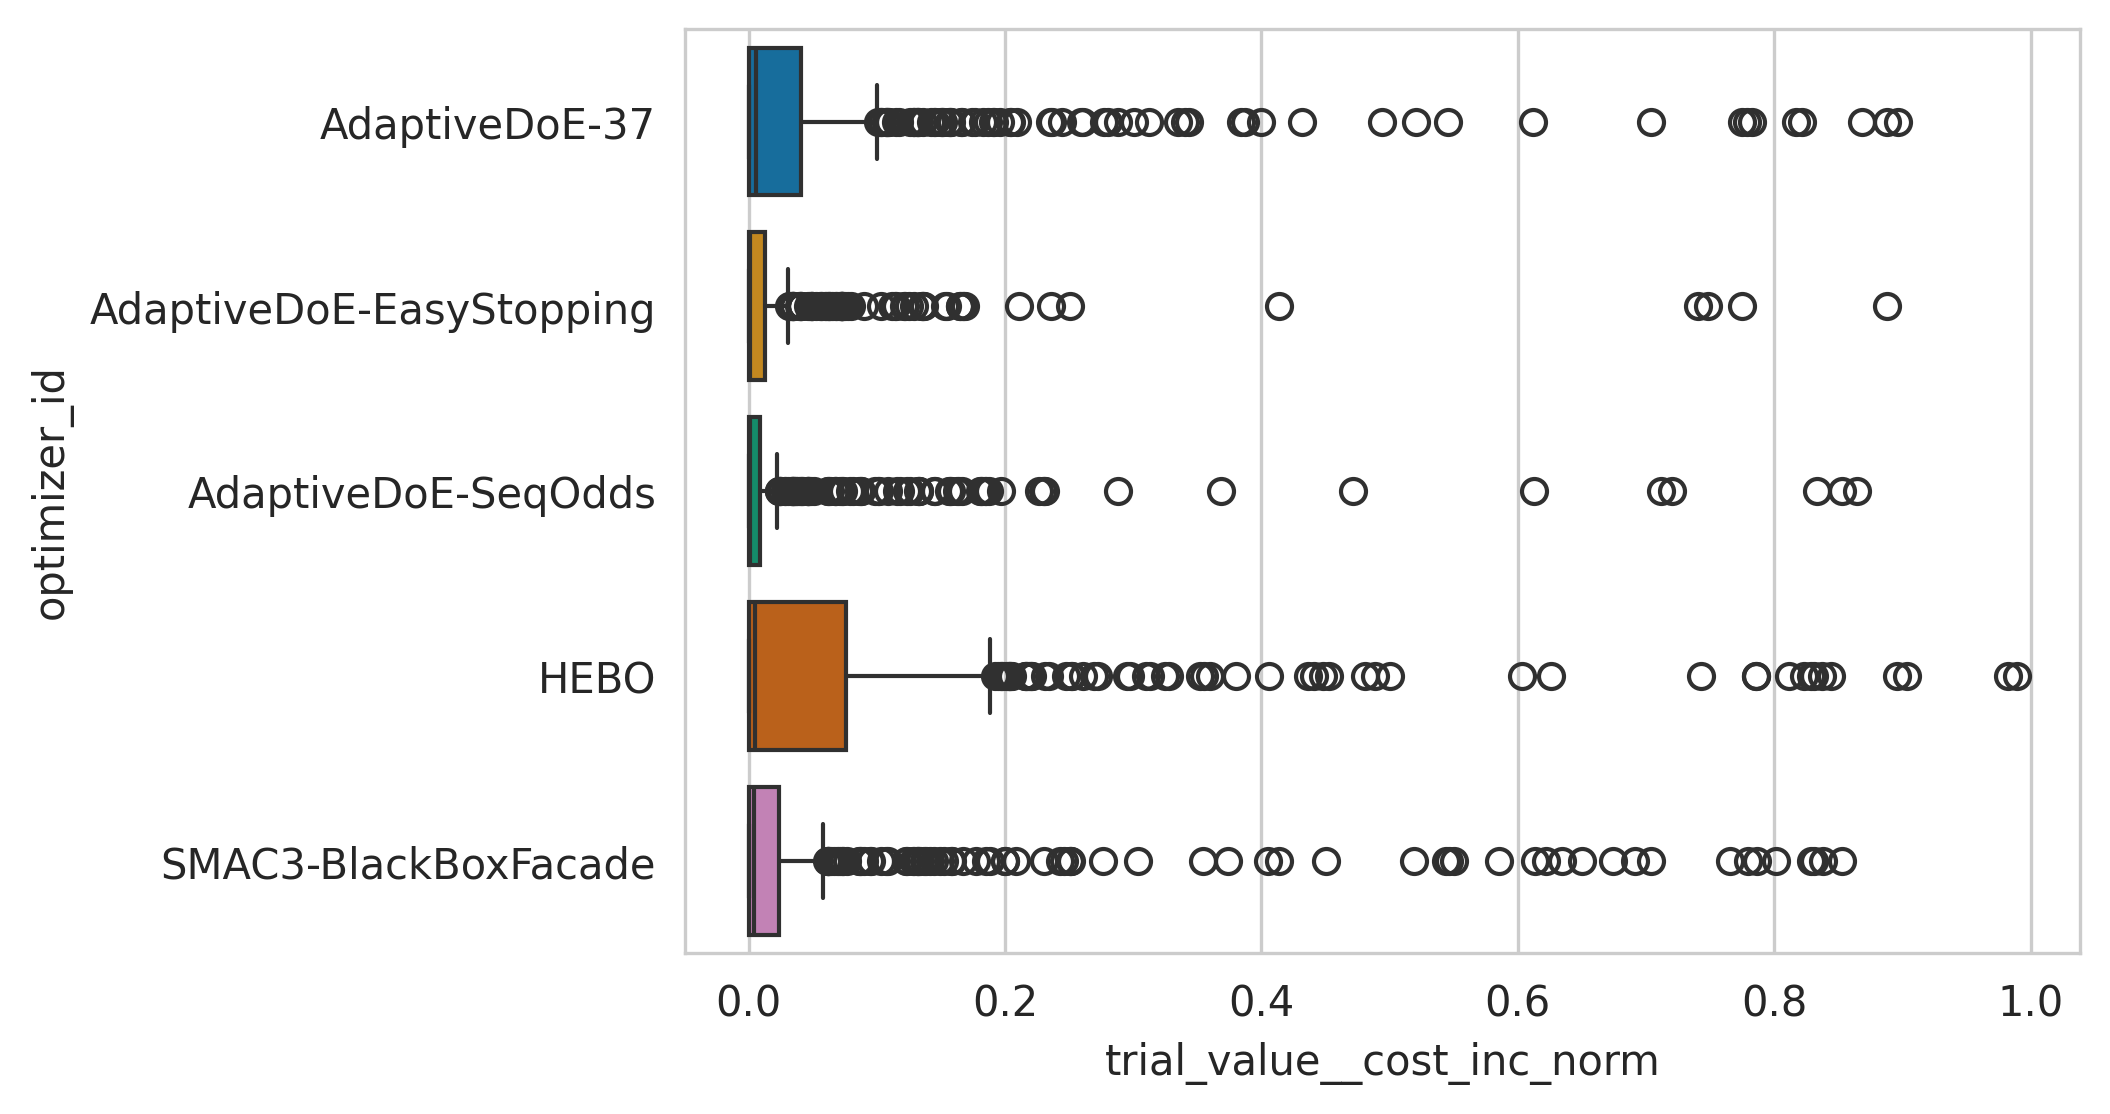

In [6]:
from carps.analysis.final_performance import plot_final_performance_boxplot

boxplot_kwargs = dict()
fig, ax = plot_final_performance_boxplot(df=perf, x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename="figures/final_performance_boxplot.pdf", figsize=(6,4), **boxplot_kwargs)

In [7]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('BBOB', 'noiseless/5/1/0', 'HEBO', 1)
('BBOB', 'noiseless/5/1/0', 'HEBO', 2)
('BBOB', 'noiseless/5/1/0', 'HEBO', 3)
('BBOB', 'noiseless/5/1/0', 'HEBO', 4)
('BBOB', 'noiseless/5/1/0', 'HEBO', 5)
('BBOB', 'noiseless/5/1/0', 'HEBO', 6)
('BBOB', 'noiseless/5/1/0', 'HEBO', 7)
('BBOB', 'noiseless/5/1/0', 'HEBO', 8)
('BBOB', 'noiseless/5/1/0', 'HEBO', 9)
('BBOB', 'noiseless/5/1/0', 'HEBO', 10)
('BBOB', 'noiseless/5/10/0', 'HEBO', 1)
('BBOB', 'noiseless/5/10/0', 'HEBO', 2)
('BBOB', 'noiseless/5/10/0', 'HEBO', 3)
('BBOB', 'noiseless/5/10/0', 'HEBO', 4)
('BBOB', 'noiseless/5/10/0', 'HEBO', 5)
('BBOB', 'noiseless/5/10/0', 'HEBO', 6)
('BBOB', 'noiseless/5/10/0', 'HEBO', 7)
('BBOB', 'noiseless/5/10/0', 'HEBO', 8)
('BBOB', 'noiseless/5/10/0', 'HEBO', 9)
('BBOB', 'noiseless/5/10/0', 'HEBO', 10)
('BBOB', 'noiseless/5/11/0', 'HEBO', 1)
('BBOB', 'noiseless/5/11/0', 'HEBO', 2)
('BBOB', 'noiseless/5/11/0', 'HEBO', 3)
('BBOB', 'noiseless/5/11/0', 'HEBO', 4)
('BBOB', 'noiseless/5/11/0', 'HEBO', 5)
('BBOB',